# Federated Unlearning

This notebook contains the code of the work described in <a href="https://arxiv.org/pdf/2207.05521.pdf">Federated Unlearning: How to Efficiently Erase a Client in FL?</a>

**Brief summary:** This work considers the case where a client (referred to as the target client) wants to opt out of federation after the federated learning process, and as a result wants to remove their contribution from the global model. We propose to perform unlearning at the client (to be erased) by reversing the learning process, i.e., training a model to maximize the local empirical loss. In particular, we formulate the unlearning problem as a constrained maximization problem by restricting to an l2-norm ball around a suitably chosen reference model to help retain some knowledge learnt from the other clients’ data. This formulation allows the client to perform the unlearning by using the Projected Gradient Descent (PGD) algorithm. To improve the performance of the unlearned model, we continue the FL process for a few rounds without the participation of the target client. Experiments
on the MNIST dataset show that the proposed unlearning method is efficient and effective.

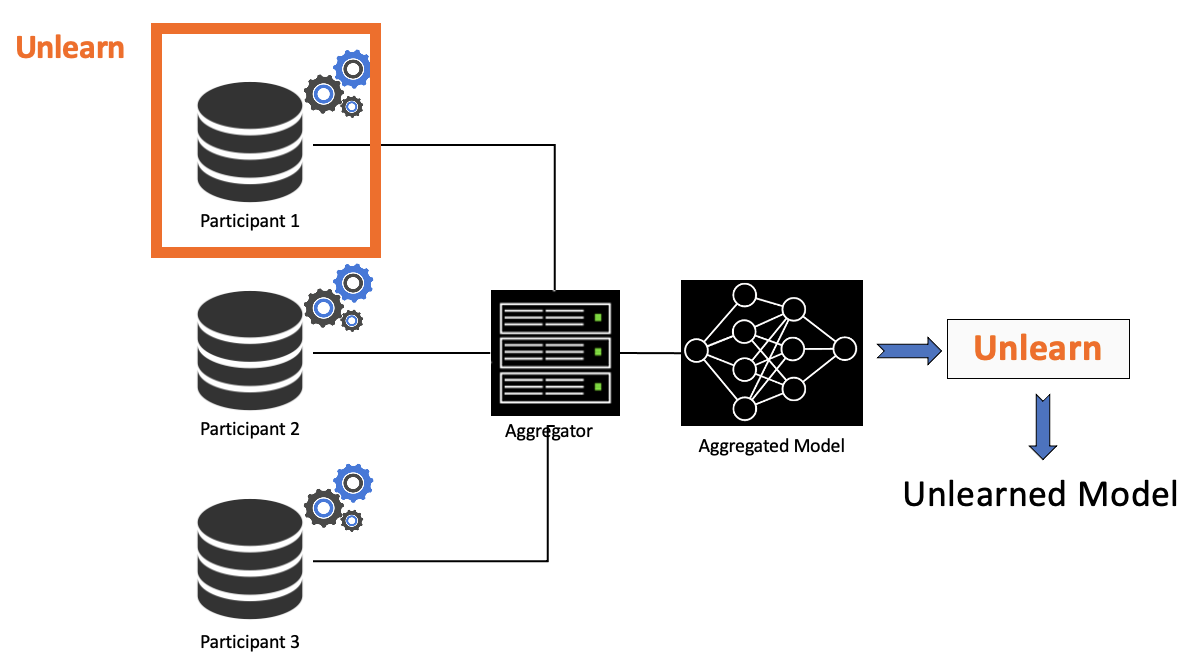

## Contents:

1. [Load prereqs and data](#section_1)
2. [Load data and backdoor a given percentage of the data of the target client](#section_2)
3. [Train the FL Model](#section_3)
4. [Unlearn the contribution of the target client](#section_4)
5. [Post-Training](#section_5)

## 1. Load prereqs 
<a id='section_1'></a>

This code is based on the repository from IBM and is used to compute FI starting from their work. To ensure the correct functioning the following steps are needed:
- clone the repository "federated unlearning.git" from the next cell code
- clone the repository "adversarial robustness toolbox" (second cell code)
- from inside the repository "adversarial robustness toolbox" use "pip install ."
- substitute the file "federated_unlearning.ipynb" from the "federated-unlearning-main" repository with this file


In [ ]:
!git clone https://github.com/IBM/federated-unlearning.git

In [ ]:
!git clone https://github.com/Trusted-AI/adversarial-robustness-toolbox.git

In [71]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import copy
import itertools
import math

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

#seeds
torch.manual_seed(0)
np.random.seed(0)

Load Backpack

In [72]:
from backpack import backpack, extend
from backpack.extensions import DiagHessian

#### FL Fusion Class Selection

In [73]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties), 
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [74]:
num_parties = 5
scale = 1
# Currently, we assume that the party to be erased is party_id = 0
party_to_be_erased = 0
num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data and backdoor a given percentage of the data of the target client
<a id='section_2'></a>

**Note:** We use the backdoor triggers (Gu et al., 2017) as an effective way to evaluate the performance of unlearning methods. In particular, the target client uses a dataset with a certain fraction of images which have a backdoor trigger inserted in them. Thus, the global FL model becomes susceptible to the backdoor trigger. Then, a successful unlearning process should produce a model that reduces the accuracy on the images with the backdoor trigger, while
maintaining a good performance on regular (clean) images. Note that we use the backdoor triggers as a way to evaluate the performance of unlearning methods; we do not consider any malicious client.

Load ART

In [75]:
import numpy as np
import art
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical

Load MNIST from ART

In [76]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train_party = x_train[0:num_samples_erased_party]
y_train_party = y_train[0:num_samples_erased_party]

Initialize Backdoor Pattern

In [77]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Insert Backdoor

In [78]:
percent_poison = .8

all_indices = np.arange(len(x_train_party))
remove_indices = all_indices[np.all(y_train_party == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
num_poison = int(percent_poison * len(target_indices))
print(f'num poison: {num_poison}')
selected_indices = np.random.choice(target_indices, num_poison, replace=False)

poisoned_data, poisoned_labels = backdoor.poison(x_train_party[selected_indices], y=example_target, broadcast=True)

poisoned_x_train = np.copy(x_train_party)
poisoned_y_train = np.argmax(y_train_party,axis=1)
for s,i in zip(selected_indices,range(len(selected_indices))):
    poisoned_x_train[s] = poisoned_data[i]
    poisoned_y_train[s] = int(np.argmax(poisoned_labels[i]))

num poison: 8636


9


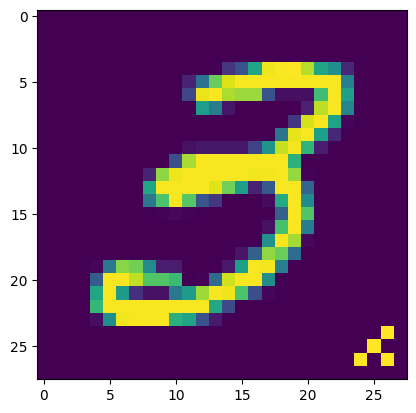

In [79]:
import matplotlib.pyplot as plt
plt.imshow(poisoned_x_train[selected_indices[0]])
print(poisoned_y_train[0])

Create PyTorch dataset from poisoned data

In [80]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

poisoned_x_train_ch = np.expand_dims(poisoned_x_train, axis = 1)
print('poisoned_x_train_ch.shape:',poisoned_x_train_ch.shape)
print('poisoned_y_train.shape:',poisoned_y_train.shape)
poisoned_dataset_train = TensorDataset(torch.Tensor(poisoned_x_train_ch),torch.Tensor(poisoned_y_train).long())
poisoned_dataloader_train = DataLoader(poisoned_dataset_train, batch_size=128, shuffle=True)

poisoned_x_train_ch.shape: (12000, 1, 28, 28)
poisoned_y_train.shape: (12000,)


Create PyTorch datasets for other parties

In [81]:
num_samples = (num_parties - 1) * num_samples_per_party
x_train_parties = x_train[num_samples_erased_party:num_samples_erased_party+num_samples] 
x_train_parties_ch = np.expand_dims(x_train_parties, axis=1)
y_train_parties = y_train[num_samples_erased_party:num_samples_erased_party+num_samples]
y_train_parties_c = np.argmax(y_train_parties, axis=1).astype(int)
print(x_train_parties_ch.shape)
print(y_train_parties_c.shape)

x_train_parties = TensorDataset(torch.Tensor(x_train_parties_ch), torch.Tensor(y_train_parties_c).long())
clean_dataset_train = torch.utils.data.random_split(x_train_parties, [num_samples_per_party for _ in range(1, num_parties)])

trainloader_lst = [poisoned_dataloader_train] 
for i in range(len(clean_dataset_train)):
    trainloader_lst.append(DataLoader(clean_dataset_train[i], batch_size=128, shuffle=True))

(48000, 1, 28, 28)
(48000,)


Create test dataloaders

In [ ]:
all_indices = np.arange(len(x_test))
remove_indices = all_indices[np.all(y_test == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
print('num poison test:', len(target_indices))
poisoned_data, poisoned_labels = backdoor.poison(x_test[target_indices], y=example_target, broadcast=True)

poisoned_x_test = np.copy(x_test)
poisoned_y_test = np.argmax(y_test,axis=1)

for s,i in zip(target_indices,range(len(target_indices))):
    poisoned_x_test[s] = poisoned_data[i]
    poisoned_y_test[s] = int(np.argmax(poisoned_labels[i]))

poisoned_x_test_ch = np.expand_dims(poisoned_x_test, axis = 1)
print(poisoned_x_test_ch.shape)
print(poisoned_y_test.shape)
poisoned_dataset_test = TensorDataset(torch.Tensor(poisoned_x_test_ch),torch.Tensor(poisoned_y_test).long())
testloader_poison = DataLoader(poisoned_dataset_test, batch_size=1000, shuffle=False)

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
print(x_test_pt.shape)
print(y_test_pt.shape)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

num poison test: 8991
(10000, 1, 28, 28)
(10000,)
(10000, 1, 28, 28)
(10000,)


Compute a Dataloader with 50 50 between clean and poisoned

In [ ]:
import random

poisoned_indices = target_indices  # These are the indices that were poisoned (8991 samples)

# Randomly select 5000 poisoned samples
sampled_poisoned_indices = random.sample(poisoned_indices, 4500)

# Extract the poisoned data
sampled_poisoned_x = np.array([poisoned_x_test_ch[i] for i in sampled_poisoned_indices])
sampled_poisoned_y = np.array([poisoned_y_test[i] for i in sampled_poisoned_indices])

# For clean samples, randomly select 5000 from the original x_test
# First expand dimensions to match the format of poisoned data
x_test_expanded = np.expand_dims(x_test, axis=1)

# Randomly select 5000 indices for clean samples
all_indices = np.arange(len(x_test))
sampled_clean_indices = random.sample(list(all_indices), 5500)

# Extract the clean data
sampled_clean_x = x_test_expanded[sampled_clean_indices]
# Use original labels from y_test (before poisoning)
sampled_clean_y = np.argmax(y_test[sampled_clean_indices], axis=1)

# Combine poisoned and clean samples
balanced_x = np.concatenate([sampled_poisoned_x, sampled_clean_x], axis=0)
balanced_y = np.concatenate([sampled_poisoned_y, sampled_clean_y], axis=0)

# Create the balanced dataset and dataloader
balanced_dataset = TensorDataset(torch.Tensor(balanced_x), torch.Tensor(balanced_y).long())
balanced_loader = DataLoader(balanced_dataset, batch_size=1000, shuffle=True)

print(f"Created balanced loader with {len(balanced_x)} samples total")
print(f"Poisoned samples: {len(sampled_poisoned_x)}, Clean samples: {len(sampled_clean_x)}")

Created balanced loader with 10000 samples total
Poisoned samples: 5000, Clean samples: 5000


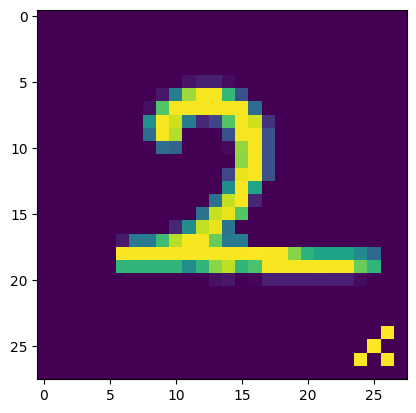

In [156]:
plt.imshow(balanced_x[0,0])

## 3. Train the FL Model
<a id='section_3'></a>

In [83]:
num_of_repeats = 1
num_fl_rounds = 10

fusion_types = ['FedAvg','Retrain']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1 

dist_Retrain = {}
loss_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [ ]:
party_models_dict = {}

class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

initial_model = FLNet2()

model_dict = {}
for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds): 
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        current_model = copy.deepcopy(initial_model)
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(num_parties):

            if fusion_key == 'Retrain' and party_id == party_to_be_erased:
                party_models.append(FLNet2())
            else:
                model = copy.deepcopy(current_model)
                model = extend(model)
                criterion = nn.CrossEntropyLoss()
                criterion = extend(criterion)
                model_update, party_loss = local_training.train(model=model, 
                                            trainloader=trainloader_lst[party_id], 
                                            criterion=criterion, opt=None)

                party_models.append(copy.deepcopy(model_update))
                party_losses.append(party_loss)

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)

        model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet2()
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')
        pois_acc = Utils.evaluate(testloader_poison, eval_model)
        pois_accuracy[fusion_key][round_num] = pois_acc
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {pois_acc}')

Global Clean Accuracy FedAvg, round 0 = 69.53
Global Backdoor Accuracy FedAvg, round 0 = 42.65
Global Clean Accuracy Retrain, round 0 = 90.1
Global Backdoor Accuracy Retrain, round 0 = 10.4
Global Clean Accuracy FedAvg, round 1 = 92.07
Global Backdoor Accuracy FedAvg, round 1 = 17.19
Global Clean Accuracy Retrain, round 1 = 93.83
Global Backdoor Accuracy Retrain, round 1 = 11.04
Global Clean Accuracy FedAvg, round 2 = 92.51
Global Backdoor Accuracy FedAvg, round 2 = 29.58
Global Clean Accuracy Retrain, round 2 = 95.84
Global Backdoor Accuracy Retrain, round 2 = 9.84
Global Clean Accuracy FedAvg, round 3 = 96.11
Global Backdoor Accuracy FedAvg, round 3 = 20.22
Global Clean Accuracy Retrain, round 3 = 96.75
Global Backdoor Accuracy Retrain, round 3 = 9.93
Global Clean Accuracy FedAvg, round 4 = 96.9
Global Backdoor Accuracy FedAvg, round 4 = 34.13
Global Clean Accuracy Retrain, round 4 = 97.45
Global Backdoor Accuracy Retrain, round 4 = 10.2
Global Clean Accuracy FedAvg, round 5 = 97.52


In [122]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets):
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Must wrap the backward pass in a backpack block
    with backpack(DiagHessian()):
        loss.backward()  # Removed retain_graph=True unless you need it
    
    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h
            
    return diag_hessian_params

# Make sure the model is properly extended
final_model = FLNet2()
final_model.load_state_dict(model_dict[fusion_key])
final_model = extend(final_model)

# Make sure the criterion is properly extended
criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)  # Changed variable name to be consistent


##################
#STANDARD DATASET#
##################
# Store sums of diag-H for each parameter
accumulated_diag_h = {}

# Accumulate over batches

for batch_idx, (inputs, targets) in enumerate(testloader_poison):
    diag_h = compute_diag_hessian(final_model, criterion, inputs, targets)
    
    # Accumulate values
    for name, value in diag_h.items():
        if name not in accumulated_diag_h:
            accumulated_diag_h[name] = value
        else:
            accumulated_diag_h[name] += value

# Calculate average
num_batches = batch_idx + 1
for name in accumulated_diag_h:
    accumulated_diag_h[name] /= num_batches

# Print final results
for name, diag_vals in accumulated_diag_h.items():
    print(f"Param {name} has diag-H shape {diag_vals.shape}")


##################
#50 50 DATASET#
##################
# Store sums of diag-H for each parameter
accumulated_diag_h_50 = {}

# Accumulate over batches

for batch_idx, (inputs, targets) in enumerate(balanced_loader):
    diag_h = compute_diag_hessian(final_model, criterion, inputs, targets)
    
    # Accumulate values
    for name, value in diag_h.items():
        if name not in accumulated_diag_h_50:
            accumulated_diag_h_50[name] = value
        else:
            accumulated_diag_h_50[name] += value

# Calculate average
num_batches = batch_idx + 1
for name in accumulated_diag_h_50:
    accumulated_diag_h_50[name] /= num_batches

# Print final results
for name, diag_vals in accumulated_diag_h_50.items():
    print(f"Param {name} has diag-H shape {diag_vals.shape}")

##################
#CLEAN DATASET#
##################
# Store sums of diag-H for each parameter
accumulated_diag_h_clean = {}

# Accumulate over batches

for batch_idx, (inputs, targets) in enumerate(testloader):
    diag_h = compute_diag_hessian(final_model, criterion, inputs, targets)
    
    # Accumulate values
    for name, value in diag_h.items():
        if name not in accumulated_diag_h_clean:
            accumulated_diag_h_clean[name] = value
        else:
            accumulated_diag_h_clean[name] += value

# Calculate average
num_batches = batch_idx + 1
for name in accumulated_diag_h_clean:
    accumulated_diag_h_clean[name] /= num_batches

# Print final results
for name, diag_vals in accumulated_diag_h_clean.items():
    print(f"Param {name} has diag-H shape {diag_vals.shape}")


Param 0.weight has diag-H shape torch.Size([32, 1, 5, 5])
Param 0.bias has diag-H shape torch.Size([32])
Param 3.weight has diag-H shape torch.Size([64, 32, 5, 5])
Param 3.bias has diag-H shape torch.Size([64])
Param 7.weight has diag-H shape torch.Size([512, 3136])
Param 7.bias has diag-H shape torch.Size([512])
Param 9.weight has diag-H shape torch.Size([10, 512])
Param 9.bias has diag-H shape torch.Size([10])
Param 0.weight has diag-H shape torch.Size([32, 1, 5, 5])
Param 0.bias has diag-H shape torch.Size([32])
Param 3.weight has diag-H shape torch.Size([64, 32, 5, 5])
Param 3.bias has diag-H shape torch.Size([64])
Param 7.weight has diag-H shape torch.Size([512, 3136])
Param 7.bias has diag-H shape torch.Size([512])
Param 9.weight has diag-H shape torch.Size([10, 512])
Param 9.bias has diag-H shape torch.Size([10])
Param 0.weight has diag-H shape torch.Size([32, 1, 5, 5])
Param 0.bias has diag-H shape torch.Size([32])
Param 3.weight has diag-H shape torch.Size([64, 32, 5, 5])
Para

In [139]:
def compute_der(tensor1, tensor2):
    # Add better numerical stability handling
    epsilon = 1e-8  # Increased epsilon
    
    # Mask to identify potential problem areas
    zero_mask = (tensor2.abs() < epsilon)
    
    # Safe ratio calculation
    ratio = torch.ones_like(tensor1)
    safe_indices = ~zero_mask
    ratio[safe_indices] = tensor1[safe_indices] / (tensor2[safe_indices] + epsilon)
    
    # Cap extreme values
    ratio = torch.clamp(ratio, 1e-8, 1e8)
    
    # Calculate derivatives with extra safety
    log_term = torch.log(ratio)
    squared_term = 0.5 * (1 - torch.pow(ratio, 2))
    
    # Handle any remaining NaNs
    result = log_term + squared_term
    result[torch.isnan(result)] = 0.0
    
    return result

# Initialize a dictionary to store information for each parameter
information = {}

# Process each parameter in the Hessian dictionaries
for name in accumulated_diag_h.keys():
    if name in accumulated_diag_h_50 and name in accumulated_diag_h_clean:
        # Print some diagnostics
        print(f"Parameter {name}:")
        print(f"  Poison min/max: {accumulated_diag_h[name].min().item():.8f}/{accumulated_diag_h[name].max().item():.8f}")
        print(f"  50% min/max: {accumulated_diag_h_50[name].min().item():.8f}/{accumulated_diag_h_50[name].max().item():.8f}")
        print(f"  Clean min/max: {accumulated_diag_h_clean[name].min().item():.8f}/{accumulated_diag_h_clean[name].max().item():.8f}")
        
        # Check for zeros or very small values
        zero_count_50 = (accumulated_diag_h_50[name].abs() < 1e-10).sum().item()
        zero_count_clean = (accumulated_diag_h_clean[name].abs() < 1e-10).sum().item()
        if zero_count_50 > 0 or zero_count_clean > 0:
            print(f"  WARNING: Found {zero_count_50} near-zeros in 50% and {zero_count_clean} in clean")
        
        # Compute second derivative integrals of FI
        der1 = compute_der(accumulated_diag_h[name], accumulated_diag_h_50[name])
        der2 = compute_der(accumulated_diag_h_50[name], accumulated_diag_h_clean[name])
        information[name] = der2 - der1
        
        # Count NaNs in result
        nan_count = torch.isnan(information[name]).sum().item()
        if nan_count > 0:
            print(f"  Still have {nan_count} NaNs in final result")

Parameter 0.weight:
  Poison min/max: 0.00000000/0.01279793
  50% min/max: 0.00000000/0.01187726
  Clean min/max: 0.00000000/0.01273612
Parameter 0.bias:
  Poison min/max: 0.00000496/0.02658666
  50% min/max: 0.00000408/0.02502781
  Clean min/max: 0.00000421/0.02621782
Parameter 3.weight:
  Poison min/max: 0.00000000/0.01928934
  50% min/max: 0.00000000/0.01862289
  Clean min/max: 0.00000000/0.01923338
Parameter 3.bias:
  Poison min/max: 0.00000857/0.00326393
  50% min/max: 0.00000846/0.00291036
  Clean min/max: 0.00000859/0.00307899
Parameter 7.weight:
  Poison min/max: 0.00000000/0.00581090
  50% min/max: 0.00000000/0.00560622
  Clean min/max: 0.00000000/0.00553011
Parameter 7.bias:
  Poison min/max: 0.00000000/0.00027548
  50% min/max: 0.00000000/0.00024289
  Clean min/max: 0.00000000/0.00026381
Parameter 9.weight:
  Poison min/max: 0.00000000/0.09493937
  50% min/max: 0.00000000/0.06654299
  Clean min/max: 0.00000000/0.08371574
Parameter 9.bias:
  Poison min/max: 0.00185576/0.00476

In [157]:
# Additional diagnostics for a specific problematic layer
problematic_param = "7.weight"  # Example - use one that has NaNs
if problematic_param in accumulated_diag_h:
    # Get flattened versions for analysis
    p_flat = accumulated_diag_h[problematic_param].flatten()
    h_flat = accumulated_diag_h_50[problematic_param].flatten()
    c_flat = accumulated_diag_h_clean[problematic_param].flatten()
    
    # Find locations of extreme or problematic values
    zero_h = (h_flat.abs() < 1e-10).nonzero().flatten()
    zero_c = (c_flat.abs() < 1e-10).nonzero().flatten()
    
    # Print some examples of problematic values
    if len(zero_h) > 0:
        indices = zero_h[:5]  # First 5 problematic indices
        print("Examples of zero/small values in 50% poisoned:")
        for idx in indices:
            i = idx.item()
            print(f"  Index {i}: Poison={p_flat[i]:.8e}, 50%={h_flat[i]:.8e}, Clean={c_flat[i]:.8e}")

Examples of zero/small values in 50% poisoned:
  Index 385: Poison=1.36361703e-11, 50%=1.41813618e-11, Clean=1.40841037e-11
  Index 426: Poison=4.92738406e-10, 50%=8.59197644e-11, Clean=3.56736238e-11
  Index 440: Poison=0.00000000e+00, 50%=2.03224698e-13, Clean=1.84545608e-12
  Index 462: Poison=1.64383223e-13, 50%=2.46088469e-13, Clean=8.17052521e-14
  Index 469: Poison=4.44220398e-13, 50%=2.20999895e-13, Clean=2.43825088e-13


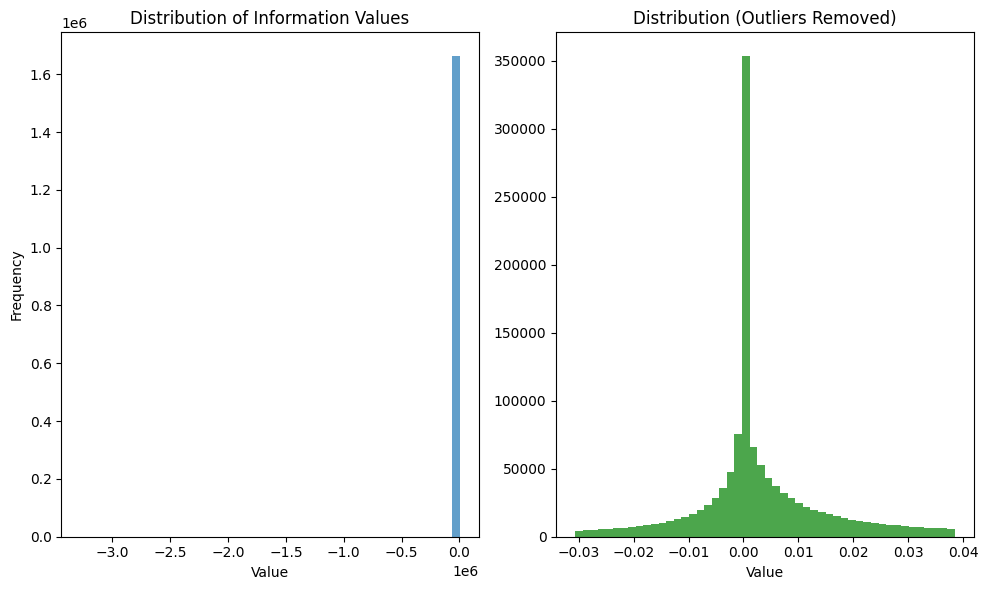

Sum of all information values: -438599744.000000
Mean: -263.681396
Min: -3277395.750000
Max: 3353.960449
Total number of values: 1663370
Sum of all information values: 3168.313477
Mean: 0.002573
Min: -0.030677
Max: 0.038453
Total number of values: 1231346


In [159]:

# 1. Sum all values in the information dictionary
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []
    
    # Iterate through each parameter's information tensor
    for name, tensor in information.items():
        # Skip any parameters with NaN values
        if torch.isnan(tensor).any():
            print(f"Skipping {name} due to NaN values")
            continue
        
        # Flatten the tensor and add to our list
        all_values.append(tensor.flatten())
    
    # Concatenate all tensors into one large tensor
    if all_values:
        combined_tensor = torch.cat(all_values)
        return combined_tensor
    else:
        print("No valid tensors found in information dictionary")
        return None

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)
    
    if combined_tensor is None:
        return
    
    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, bins=50, alpha=0.7)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    
    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, bins=50, alpha=0.7, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item():.6f}")
    print(f"Min: {combined_tensor.min().item():.6f}")
    print(f"Max: {combined_tensor.max().item():.6f}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item():.6f}")
    print(f"Min: {filtered_values.min().item():.6f}")
    print(f"Max: {filtered_values.max().item():.6f}")
    print(f"Total number of values: {len(filtered_values)}")

# Call the plotting function
plot_information(information)

In [14]:
for fusion_key in fusion_types:
    current_model_state_dict = model_dict[fusion_key]
    current_model = copy.deepcopy(initial_model)
    current_model.load_state_dict(current_model_state_dict)
    clean_acc = Utils.evaluate(testloader, current_model)
    print(f'Clean Accuracy {fusion_key}: {clean_acc}')
    pois_acc = Utils.evaluate(testloader_poison, current_model)
    print(f'Backdoor Accuracy {fusion_key}: {pois_acc}')

Clean Accuracy FedAvg: 98.29
Backdoor Accuracy FedAvg: 85.85
Clean Accuracy Retrain: 98.5
Backdoor Accuracy Retrain: 10.02


## 4. Unlearn the contribution of the target client 
<a id='section_4'></a>

In [15]:
num_updates_in_epoch = None  
num_local_epochs_unlearn = 5 
lr = 0.01
distance_threshold = 2.2
clip_grad = 5


initial_model = FLNet()
unlearned_model_dict = {}
for fusion_key in fusion_types_unlearn:
    if fusion_key == 'Retrain':
        unlearned_model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

clean_accuracy_unlearn = {}
pois_accuracy_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn[fusion_key] = 0
    pois_accuracy_unlearn[fusion_key] = 0

for fusion_key in fusion_types:
    if fusion_key == 'Retrain':
        continue

    initial_model = FLNet()
    fedavg_model_state_dict = copy.deepcopy(model_dict[fusion_key])
    fedavg_model = copy.deepcopy(initial_model)
    fedavg_model.load_state_dict(fedavg_model_state_dict)

    party_models = copy.deepcopy(party_models_dict[fusion_key])
    party0_model = copy.deepcopy(party_models[0])

    #compute reference model
    #w_ref = N/(N-1)w^T - 1/(N-1)w^{T-1}_i = \sum{i \ne j}w_j^{T-1}
    model_ref_vec = num_parties / (num_parties - 1) * nn.utils.parameters_to_vector(fedavg_model.parameters()) \
                               - 1 / (num_parties - 1) * nn.utils.parameters_to_vector(party0_model.parameters())

    #compute threshold
    model_ref = copy.deepcopy(initial_model)
    nn.utils.vector_to_parameters(model_ref_vec, model_ref.parameters())

    eval_model = copy.deepcopy(model_ref)
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for Reference Model = {unlearn_clean_acc}')
    unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for Reference Model = {unlearn_pois_acc}')

    dist_ref_random_lst = []
    for _ in range(10):
        dist_ref_random_lst.append(Utils.get_distance(model_ref, FLNet()))    

    print(f'Mean distance of Reference Model to random: {np.mean(dist_ref_random_lst)}')
    threshold = np.mean(dist_ref_random_lst) / 3
    print(f'Radius for model_ref: {threshold}')
    dist_ref_party = Utils.get_distance(model_ref, party0_model)
    print(f'Distance of Reference Model to party0_model: {dist_ref_party}')


    ###############################################################
    #### Unlearning
    ###############################################################
    model = copy.deepcopy(model_ref)

    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 

    model.train()
    flag = False
    for epoch in range(num_local_epochs_unlearn):
        print('------------', epoch)
        if flag:
            break
        for batch_id, (x_batch, y_batch) in enumerate(trainloader_lst[party_to_be_erased]):

            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_joint = -loss # negate the loss for gradient ascent
            loss_joint.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            opt.step()

            with torch.no_grad():
                distance = Utils.get_distance(model, model_ref)
                if distance > threshold:
                    dist_vec = nn.utils.parameters_to_vector(model.parameters()) - nn.utils.parameters_to_vector(model_ref.parameters())
                    dist_vec = dist_vec/torch.norm(dist_vec)*np.sqrt(threshold)
                    proj_vec = nn.utils.parameters_to_vector(model_ref.parameters()) + dist_vec
                    nn.utils.vector_to_parameters(proj_vec, model.parameters())
                    distance = Utils.get_distance(model, model_ref)

            distance_ref_party_0 = Utils.get_distance(model, party0_model)
            print('Distance from the unlearned model to party 0:', distance_ref_party_0.item())

            if distance_ref_party_0 > distance_threshold:
                flag = True
                break

            if num_updates_in_epoch is not None and batch_id >= num_updates_in_epoch:
                break
    ####################################################################                           

    unlearned_model = copy.deepcopy(model)
    unlearned_model_dict[fusion_types_unlearn[1]] = unlearned_model.state_dict() 

    eval_model = FLNet()
    eval_model.load_state_dict(unlearned_model_dict[fusion_types_unlearn[1]])
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for UN-Local Model = {unlearn_clean_acc}')
    clean_accuracy_unlearn[fusion_types_unlearn[1]] =  unlearn_clean_acc
    pois_unlearn_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for UN-Local Model = {pois_unlearn_acc}')
    pois_accuracy_unlearn[fusion_types_unlearn[1]] =  pois_unlearn_acc

Clean Accuracy for Reference Model = 98.33
Backdoor Accuracy for Reference Model = 72.93
Mean distance of Reference Model to random: 456.2486267089844
Radius for model_ref: 152.08287048339844
Distance of Reference Model to party0_model: 0.4490634500980377
------------ 0
Distance from the unlearned model to party 0: 0.47730496525764465
Distance from the unlearned model to party 0: 0.543337881565094
Distance from the unlearned model to party 0: 0.6671583652496338
Distance from the unlearned model to party 0: 0.8700048327445984
Distance from the unlearned model to party 0: 1.176328420639038
Distance from the unlearned model to party 0: 1.6044178009033203
Distance from the unlearned model to party 0: 2.1715099811553955
Distance from the unlearned model to party 0: 2.8981709480285645
------------ 1
Clean Accuracy for UN-Local Model = 65.52
Backdoor Accuracy for UN-Local Model = 0.0


## 5. Post-Training
<a id='section_5'></a>

In [16]:
num_fl_after_unlearn_rounds = num_fl_rounds
num_updates_in_epoch = 50
num_local_epochs = 1 

clean_accuracy_unlearn_fl_after_unlearn = {}
pois_accuracy_unlearn_fl_after_unlearn = {}
loss_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    pois_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    loss_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)

    
for round_num in range(num_fl_after_unlearn_rounds):

    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types_unlearn:
        # Reduce num_parties by 1 to remove the erased party
        fusion = FL_round_fusion_selection(num_parties=num_parties - 1, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(unlearned_model_dict[fusion_key])    
        current_model = FLNet()
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(1, num_parties):
            model = copy.deepcopy(current_model)
            model_update, party_loss = local_training.train(model=model, 
                                        trainloader=trainloader_lst[party_id], 
                                        criterion=None, opt=None)

            party_models.append(copy.deepcopy(model_update))
            party_losses.append(party_loss)

        loss_unlearn[fusion_key][round_num] = np.mean(party_losses)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)
        unlearned_model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {unlearn_clean_acc}')
        clean_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_clean_acc
        unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {unlearn_pois_acc}')
        pois_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_pois_acc


Global Clean Accuracy Retrain, round 0 = 76.61
Global Backdoor Accuracy Retrain, round 0 = 11.08
Global Clean Accuracy Unlearn, round 0 = 96.91
Global Backdoor Accuracy Unlearn, round 0 = 11.17
Global Clean Accuracy Retrain, round 1 = 90.79
Global Backdoor Accuracy Retrain, round 1 = 10.68
Global Clean Accuracy Unlearn, round 1 = 97.58
Global Backdoor Accuracy Unlearn, round 1 = 11.6
Global Clean Accuracy Retrain, round 2 = 93.1
Global Backdoor Accuracy Retrain, round 2 = 10.68
Global Clean Accuracy Unlearn, round 2 = 97.79
Global Backdoor Accuracy Unlearn, round 2 = 11.49
Global Clean Accuracy Retrain, round 3 = 94.41
Global Backdoor Accuracy Retrain, round 3 = 10.87
Global Clean Accuracy Unlearn, round 3 = 98.02
Global Backdoor Accuracy Unlearn, round 3 = 11.7
Global Clean Accuracy Retrain, round 4 = 94.97
Global Backdoor Accuracy Retrain, round 4 = 10.73
Global Clean Accuracy Unlearn, round 4 = 98.18
Global Backdoor Accuracy Unlearn, round 4 = 12.06
Global Clean Accuracy Retrain, ro

Compare the performance of the proposed unlearning method with retraining from scratch (baseline)

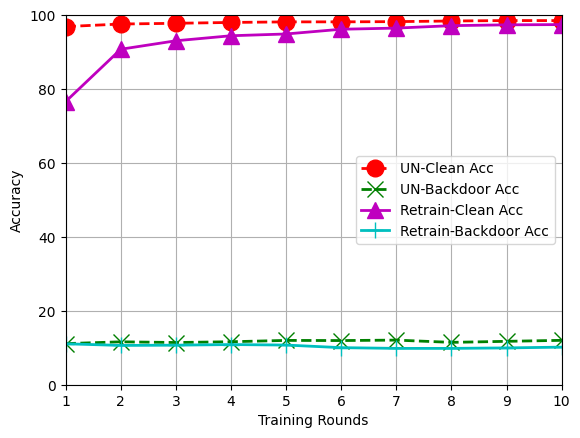

In [ ]:
import matplotlib.pyplot as plt

fl_rounds = [i for i in range(1, num_fl_rounds + 1)]

plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'ro--', linewidth=2, markersize=12, label='UN-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'gx--', linewidth=2, markersize=12, label='UN-Backdoor Acc') 
plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Retrain'], 'm^-', linewidth=2, markersize=12, label='Retrain-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Retrain'], 'c+-', linewidth=2, markersize=12, label='Retrain-Backdoor Acc')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 100])
plt.xlim([1, 10])
plt.legend()
plt.show()